# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [0]:
student1 = "Manu Srinath Halvagal"
student2 = "Hannes Kaspar Rovina"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


### Plotting

In [3]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [4]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

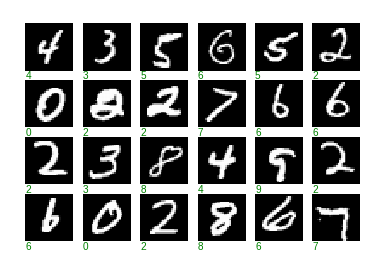

In [0]:
figure = plot_some_samples(x_train, y_train)

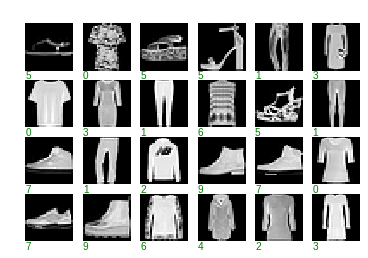

In [0]:
figure = plot_some_samples(x_fashion_train, y_fashion_train)

Answer to question 2:

The green numbers indicate the corresponding ground-truth label of each example image

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [5]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [6]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

#### 2.1

In [7]:
def construct_mlp_for_mnist(num_hidden_layers, input_dim, hidden_layer_sizes = [], activations=[]):
  net = Sequential()
  
  if num_hidden_layers > 0:
    net.add(Dense(hidden_layer_sizes[0], activation=activations[0], input_dim=input_dim))
    for i in range(1, num_hidden_layers):
      net.add(Dense(hidden_layer_sizes[i], activation=activations[i]))
    
    net.add(Dense(10, activation='softmax'))

  else:    
    net.add(Dense(10, activation='softmax', input_dim=input_dim))
    
  return net

#### 2.2-2.6

In [0]:
minibatch_size = 128
max_epochs = 150

In [0]:
net_no_hidden = construct_mlp_for_mnist(0, x_train.shape[1])
net_no_hidden.summary()
net_no_hidden.compile(loss='categorical_crossentropy',
                      optimizer=SGD(),
                      metrics=['accuracy'])

history_no_hidden = net_no_hidden.fit(x_train, y_train,
                                      batch_size=minibatch_size,
                                      epochs=max_epochs,
                                      verbose=1,
                                      validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 1s 21us/step - loss: 1.2600 - acc: 0.7086 - val_loss: 0.8014 - val_acc: 0.8359
Epoch 2/150
60000/60000 [==============================] - 1s 17us/step - loss: 0.7086 - acc: 0.8438 - val_loss: 0.6017 - val_acc: 0.8625
Epoch 3/150
60000/60000 [==============================] - 1s 16us/step - loss: 0.5827 - acc: 0.8608 - val_loss: 0.5214 - val_acc: 0.8752
Epoch 4/150
60000/60000 [==============================] - 1s 16us/step - loss: 0.5222 - acc: 0.8713 - val_loss: 0.4767 - val_acc: 0.8813
Epoch 5/150
60000/60000 [==============================] - 1s 16us

Epoch 115/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2830 - acc: 0.9216 - val_loss: 0.2793 - val_acc: 0.9218
Epoch 116/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2828 - acc: 0.9214 - val_loss: 0.2793 - val_acc: 0.9207
Epoch 117/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2826 - acc: 0.9217 - val_loss: 0.2791 - val_acc: 0.9211
Epoch 118/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2823 - acc: 0.9218 - val_loss: 0.2790 - val_acc: 0.9214
Epoch 119/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2821 - acc: 0.9219 - val_loss: 0.2788 - val_acc: 0.9216
Epoch 120/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2818 - acc: 0.9219 - val_loss: 0.2786 - val_acc: 0.9213
Epoch 121/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2817 - acc: 0.9218 - val_loss: 0.2786 - val_acc: 0.9219
Epoch 122/150
60000/

#### 2.7 

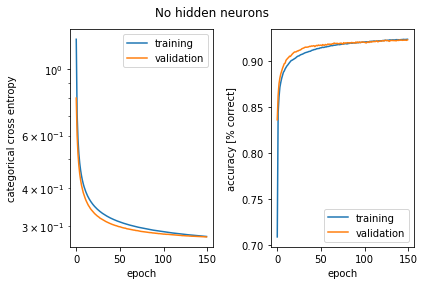

In [0]:
figure = plot_history(history_no_hidden, 'No hidden neurons')

#### 2.8

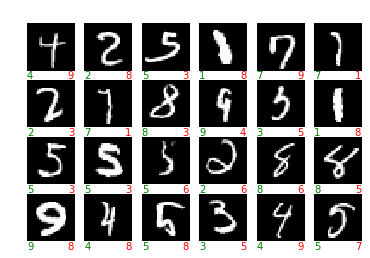

In [0]:
yhat_test = net_no_hidden.predict(x_test)
yhat_test = np.argmax(yhat_test, axis=1)
yhat_test = keras.utils.to_categorical(yhat_test)

error_indices = np.nonzero((yhat_test != y_test).any(axis=1))
figure = plot_some_samples(x_test, y_test, yhat_test, np.squeeze(error_indices))

The images above are the examples that have been misclassified by our network. The number in green is the ground-truth, and the number in red is the label with the maximum probability given by the output softmax of the trained network.

#### 2.9

In [0]:
#Mnist fashion
net_no_hidden_fashion = construct_mlp_for_mnist(0, x_fashion_train.shape[1])
net_no_hidden_fashion.summary()
net_no_hidden_fashion.compile(loss='categorical_crossentropy',
                      optimizer=SGD(),
                      metrics=['accuracy'])

history_no_hidden_fashion = net_no_hidden_fashion.fit(x_fashion_train, y_fashion_train,
                                      batch_size=minibatch_size,
                                      epochs=max_epochs,
                                      verbose=1,
                                      validation_data=(x_fashion_test, y_fashion_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 1s 20us/step - loss: 1.1855 - acc: 0.6271 - val_loss: 0.8861 - val_acc: 0.6959
Epoch 2/150
60000/60000 [==============================] - 1s 16us/step - loss: 0.7951 - acc: 0.7384 - val_loss: 0.7552 - val_acc: 0.7475
Epoch 3/150
60000/60000 [==============================] - 1s 16us/step - loss: 0.7043 - acc: 0.7713 - val_loss: 0.6936 - val_acc: 0.7663
Epoch 4/150
60000/60000 [==============================] - 1s 17us/step - loss: 0.6553 - acc: 0.7880 - val_loss: 0.6563 - val_acc: 0.7818
Epoch 5/150
60000/60000 [==============================] - 1s 17us

Epoch 115/150
60000/60000 [==============================] - 1s 16us/step - loss: 0.4112 - acc: 0.8597 - val_loss: 0.4526 - val_acc: 0.8413
Epoch 116/150
60000/60000 [==============================] - 1s 16us/step - loss: 0.4109 - acc: 0.8603 - val_loss: 0.4521 - val_acc: 0.8429
Epoch 117/150
60000/60000 [==============================] - 1s 17us/step - loss: 0.4106 - acc: 0.8601 - val_loss: 0.4527 - val_acc: 0.8416
Epoch 118/150
60000/60000 [==============================] - 1s 16us/step - loss: 0.4103 - acc: 0.8599 - val_loss: 0.4525 - val_acc: 0.8416
Epoch 119/150
60000/60000 [==============================] - 1s 17us/step - loss: 0.4101 - acc: 0.8605 - val_loss: 0.4516 - val_acc: 0.8418
Epoch 120/150
60000/60000 [==============================] - 1s 16us/step - loss: 0.4097 - acc: 0.8603 - val_loss: 0.4517 - val_acc: 0.8421
Epoch 121/150
60000/60000 [==============================] - 1s 17us/step - loss: 0.4096 - acc: 0.8606 - val_loss: 0.4512 - val_acc: 0.8434
Epoch 122/150
60000/

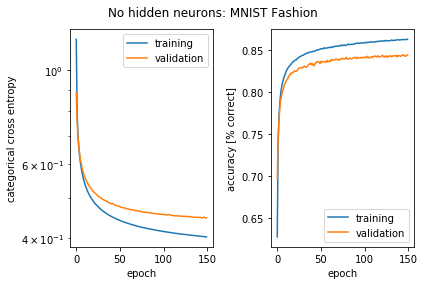

In [0]:
figure = plot_history(history_no_hidden_fashion,'No hidden neurons: MNIST Fashion')

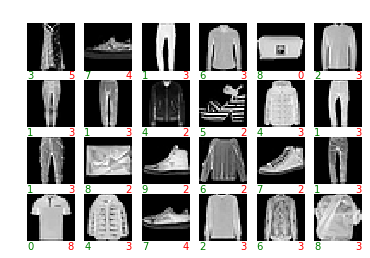

In [0]:
yhat_fashion_test = net_no_hidden.predict(x_fashion_test)
yhat_fashion_test = np.argmax(yhat_fashion_test, axis=1)
yhat_fashion_test = keras.utils.to_categorical(yhat_fashion_test)

error_indices_fashion = np.nonzero((yhat_fashion_test != y_fashion_test).any(axis=1))
figure = plot_some_samples(x_fashion_test, y_fashion_test, yhat_fashion_test, np.squeeze(error_indices_fashion))

Answer to question 10:

In [ ]:
#TODO Hannes: What is this question?

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

#### 3.1

In [0]:
net_one_hidden = construct_mlp_for_mnist(1, x_train.shape[1], [128], ['relu'])
net_one_hidden.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


#### 3.2

In [0]:
max_epochs = 50

In [0]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
history_sgd_lr = []
for lr in learning_rates:
    net_one_hidden = construct_mlp_for_mnist(1, x_train.shape[1], [128], ['relu'])
    net_one_hidden.compile(loss='categorical_crossentropy',
                           optimizer=SGD(lr),
                           metrics=['accuracy'])

    history_sgd_lr.append(net_one_hidden.fit(x_train, y_train,
                                             batch_size=minibatch_size,
                                             epochs=max_epochs,
                                             verbose=1,
                                             validation_data=(x_test, y_test)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 46us/step - loss: 2.1620 - acc: 0.2407 - val_loss: 1.9614 - val_acc: 0.4693
Epoch 2/50
60000/60000 [==============================] - 2s 35us/step - loss: 1.8006 - acc: 0.5875 - val_loss: 1.6277 - val_acc: 0.6752
Epoch 3/50
60000/60000 [==============================] - 2s 35us/step - loss: 1.5032 - acc: 0.7095 - val_loss: 1.3547 - val_acc: 0.7480
Epoch 4/50
60000/60000 [==============================] - 2s 35us/step - loss: 1.2663 - acc: 0.7608 - val_loss: 1.1450 - val_acc: 0.7894
Epoch 5/50
60000/60000 [==============================] - 2s 35us/step - loss: 1.0872 - acc: 0.7912 - val_loss: 0.9898 - val_acc: 0.8112
Epoch 6/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.9546 - acc: 0.8115 - val_loss: 0.8756 - val_acc: 0.8272
Epoch 7/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.8557 - acc: 0.8262 - val_loss: 0.7897 - val_acc

In [0]:
for i, lr in enumerate(learning_rates):
    print('SGD with learning rate ' + str(lr) + ' gave validation accuracy ' + str(history_sgd_lr[i].history['val_acc'][-1]))

SGD with learning rate 0.001 gave validation accuracy 0.9081
SGD with learning rate 0.005 gave validation accuracy 0.9427
SGD with learning rate 0.01 gave validation accuracy 0.96
SGD with learning rate 0.05 gave validation accuracy 0.9769
SGD with learning rate 0.1 gave validation accuracy 0.9785
SGD with learning rate 0.5 gave validation accuracy 0.9817
SGD with learning rate 1.0 gave validation accuracy 0.9767
SGD with learning rate 5.0 gave validation accuracy 0.101


#### 3.3

In [0]:
learning_rates = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
history_adam_lr = []
for lr in learning_rates:
    net_one_hidden = construct_mlp_for_mnist(1, x_train.shape[1], [128], ['relu'])
    net_one_hidden.compile(loss='categorical_crossentropy',
                           optimizer=Adam(lr),
                           metrics=['accuracy'])

    history_adam_lr.append(net_one_hidden.fit(x_train, y_train,
                                           batch_size=minibatch_size,
                                           epochs=max_epochs,
                                           verbose=1,
                                           validation_data=(x_test, y_test)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.4671 - acc: 0.8758 - val_loss: 0.2527 - val_acc: 0.9306
Epoch 2/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.2237 - acc: 0.9376 - val_loss: 0.1853 - val_acc: 0.9456
Epoch 3/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.1728 - acc: 0.9513 - val_loss: 0.1584 - val_acc: 0.9540
Epoch 4/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.1413 - acc: 0.9599 - val_loss: 0.1320 - val_acc: 0.9616
Epoch 5/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.1191 - acc: 0.9669 - val_loss: 0.1193 - val_acc: 0.9636
Epoch 6/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.1030 - acc: 0.9709 - val_loss: 0.1064 - val_acc: 0.9674
Epoch 7/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.0898 - acc: 0.9747 - val_loss: 0.0996 - val_acc

In [0]:
for i, lr in enumerate(learning_rates):
    print('Adam with learning rate ' + str(lr) + ' gave validation accuracy ' + str(history_adam_lr[i].history['val_acc'][-1]))

Adam with learning rate 0.0005 gave validation accuracy 0.9795
Adam with learning rate 0.001 gave validation accuracy 0.9817
Adam with learning rate 0.005 gave validation accuracy 0.9744
Adam with learning rate 0.01 gave validation accuracy 0.9751
Adam with learning rate 0.05 gave validation accuracy 0.9124
Adam with learning rate 0.1 gave validation accuracy 0.7569
Adam with learning rate 0.5 gave validation accuracy 0.1032


In [0]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

#### 3.4

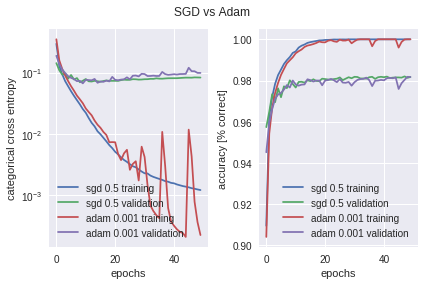

In [0]:
figure = comparison_plot(history_sgd_lr[5], history_adam_lr[1], 'sgd 0.5', 'adam 0.001', 'SGD vs Adam')

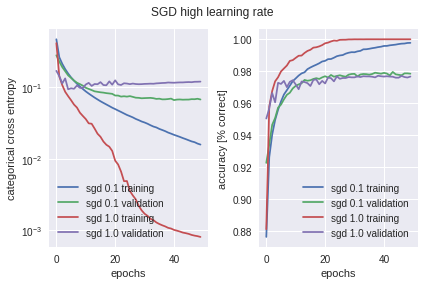

In [0]:
figure = comparison_plot(history_sgd_lr[4], history_sgd_lr[-2], 'sgd 0.1', 'sgd 1.0', 'SGD high learning rate')

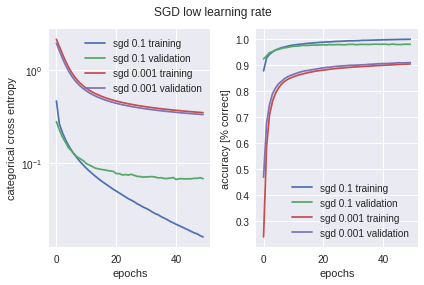

In [0]:
figure = comparison_plot(history_sgd_lr[4], history_sgd_lr[0], 'sgd 0.1', 'sgd 0.001', 'SGD low learning rate')

#### 3.5

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) The model gets driven into the overfitting regime very quickly with poor performance on the validation data

B) Learning becomes very slow and would take a very large number of epochs to converge.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: Adam starts to overfit around 10 epochs.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: Overfitting can be inferred only from the loss curves as the point where the validation loss starts to increase. There is a less visible qualitative change in the accuracy curves at this point, wherein that the validation accuracy flattens out and stops increasing.

#### 3.6

In [79]:
net_one_hidden_fashion = construct_mlp_for_mnist(1, x_train.shape[1], [50], ['relu'])
net_one_hidden_fashion.summary()

max_epochs = 100

net_one_hidden_fashion.compile(loss='categorical_crossentropy',
                       optimizer=Adam(),
                       metrics=['accuracy'])

history_one_hidden_fashion = net_one_hidden_fashion.fit(x_fashion_train, y_fashion_train,
                                        batch_size=minibatch_size,
                                        epochs=max_epochs,
                                        verbose=1,
                                        validation_data=(x_fashion_test, y_fashion_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_75 (Dense)             (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 80us/step - loss: 0.6247 - acc: 0.7881 - val_loss: 0.4822 - val_acc: 0.8341
Epoch 2/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.4364 - acc: 0.8488 - val_loss: 0.4503 - val_acc: 0.8426
Epoch 3/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.3996 - acc: 0.8616 - val_loss: 0.4178 - val_acc: 0.8561
Epoch 4/100
60000/60000 [==============================] - 2s 32us/ste

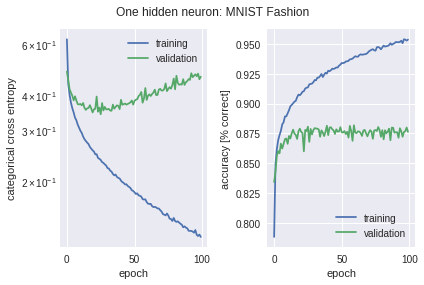

In [80]:
figure = plot_history(history_one_hidden_fashion,'One hidden neuron: MNIST Fashion')

In [81]:
np.max(history_one_hidden_fashion.history['val_acc'])

0.8818

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

#### 4.1

In [10]:
history_ex4 = []
max_epochs = 20
minibatch_size = 128

hidden_neurons = [10, 25, 50, 100, 250, 500, 1000]

for hn in hidden_neurons:
    print('Training net with ' + str(hn) + ' hidden neurons') 
    net_ex4 = construct_mlp_for_mnist(1, x_train.shape[1], [hn], ['relu'])
    net_ex4.compile(loss='categorical_crossentropy',
                    optimizer=Adam(),
                    metrics=['accuracy'])

    history_ex4.append(net_ex4.fit(x_train, y_train,
                                   batch_size=minibatch_size,
                                   epochs=max_epochs,
                                   verbose=1,
                                   validation_data=(x_test, y_test)))

Training net with 10 hidden neurons
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.7896 - acc: 0.7639 - val_loss: 0.3930 - val_acc: 0.8919
Epoch 2/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.3591 - acc: 0.9004 - val_loss: 0.3165 - val_acc: 0.9121
Epoch 3/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.3070 - acc: 0.9144 - val_loss: 0.2859 - val_acc: 0.9191
Epoch 4/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.2842 - acc: 0.9204 - val_loss: 0.2712 - val_acc: 0.9222
Epoch 5/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.2688 - acc: 0.9251 - val_loss: 0.2605 - val_acc: 0.9256
Epoch 6/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.2591 - acc: 0.9279 - val_loss: 0.2525 - val_acc: 0.9273
Epoch 7/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.2510 - acc:

Epoch 19/20
60000/60000 [==============================] - 1s 21us/step - loss: 0.0354 - acc: 0.9902 - val_loss: 0.0926 - val_acc: 0.9733
Epoch 20/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.0328 - acc: 0.9910 - val_loss: 0.0890 - val_acc: 0.9753
Training net with 100 hidden neurons
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.3846 - acc: 0.8966 - val_loss: 0.2095 - val_acc: 0.9408
Epoch 2/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.1764 - acc: 0.9499 - val_loss: 0.1493 - val_acc: 0.9554
Epoch 3/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.1301 - acc: 0.9631 - val_loss: 0.1276 - val_acc: 0.9616
Epoch 4/20
60000/60000 [==============================] - 2s 28us/step - loss: 0.1025 - acc: 0.9703 - val_loss: 0.1093 - val_acc: 0.9670
Epoch 5/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.0835 - a

60000/60000 [==============================] - 5s 84us/step - loss: 0.0100 - acc: 0.9967 - val_loss: 0.0820 - val_acc: 0.9802
Epoch 17/20
60000/60000 [==============================] - 5s 79us/step - loss: 0.0073 - acc: 0.9978 - val_loss: 0.0684 - val_acc: 0.9821
Epoch 18/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.0025 - acc: 0.9995 - val_loss: 0.0751 - val_acc: 0.9823
Epoch 19/20
60000/60000 [==============================] - 5s 75us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0713 - val_acc: 0.9832
Epoch 20/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0748 - val_acc: 0.9832
Training net with 1000 hidden neurons
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 156us/step - loss: 0.2386 - acc: 0.9313 - val_loss: 0.1136 - val_acc: 0.9663
Epoch 2/20
60000/60000 [==============================] - 9s 148us/step - loss: 0.0922 - acc: 0.

#### 4.2

In [11]:
min_loss = []
max_acc = []
min_train_loss = []
max_train_acc = []
for i,hn in enumerate(hidden_neurons):
    val_loss = history_ex4[i].history['val_loss']
    min_loss.append(min(val_loss))
    val_acc = history_ex4[i].history['val_acc']
    max_acc.append(max(val_acc))
    
    train_loss = history_ex4[i].history['loss']
    min_train_loss.append(min(train_loss))
    train_acc = history_ex4[i].history['acc']
    max_train_acc.append(max(train_acc))

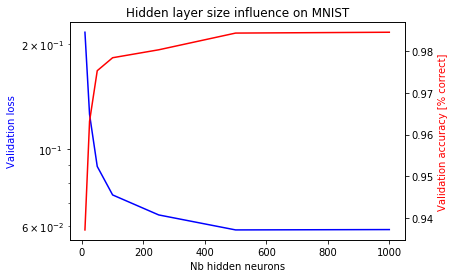

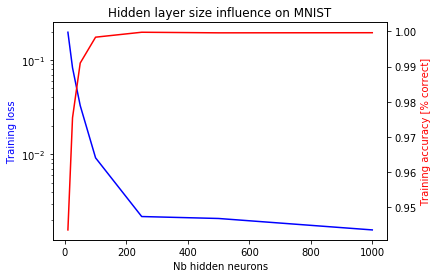

In [12]:
title = 'Hidden layer size influence on MNIST'

fig = plt.figure(1)
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.set_title(title, fontsize='large')

ax1.plot(hidden_neurons, min_loss, 'b-', label='val loss MNIST')
ax1.set_yscale('log')
ax2.plot(hidden_neurons, max_acc, 'r-', label='val acc MNIST')
ax1.set_ylabel('Validation loss', color='blue')
ax2.set_ylabel('Validation accuracy [% correct]', color='red')
ax1.set_xlabel('Nb hidden neurons');

fig = plt.figure(2)
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.set_title(title, fontsize='large')

ax1.plot(hidden_neurons, min_train_loss, 'b-', label='train loss MNIST')
ax1.set_yscale('log')
ax2.plot(hidden_neurons, max_train_acc, 'r-', label='train acc MNIST')
ax1.set_ylabel('Training loss', color='blue')
ax2.set_ylabel('Training accuracy [% correct]', color='red')
ax1.set_xlabel('Nb hidden neurons');


#### 4.3

In [13]:
history_ex4_fashion = []
max_epochs = 20
minibatch_size = 128

hidden_neurons = [10, 25, 50, 100, 250, 500, 1000]

for hn in hidden_neurons:
    print('Training net with ' + str(hn) + ' hidden neurons') 
    net_ex4_fashion = construct_mlp_for_mnist(1, x_fashion_train.shape[1], [hn], ['relu'])
    net_ex4_fashion.compile(loss='categorical_crossentropy',
                            optimizer=Adam(),
                            metrics=['accuracy'])

    history_ex4_fashion.append(net_ex4_fashion.fit(x_fashion_train, y_fashion_train,
                                                   batch_size=minibatch_size,
                                                   epochs=max_epochs,
                                                   verbose=1,
                                                   validation_data=(x_fashion_test, y_fashion_test)))

Training net with 10 hidden neurons
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.8683 - acc: 0.7035 - val_loss: 0.5845 - val_acc: 0.7978
Epoch 2/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.5278 - acc: 0.8206 - val_loss: 0.5272 - val_acc: 0.8196
Epoch 3/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.4855 - acc: 0.8332 - val_loss: 0.5142 - val_acc: 0.8210
Epoch 4/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.4653 - acc: 0.8404 - val_loss: 0.4871 - val_acc: 0.8310
Epoch 5/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.4513 - acc: 0.8438 - val_loss: 0.4812 - val_acc: 0.8325
Epoch 6/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.4397 - acc: 0.8483 - val_loss: 0.4653 - val_acc: 0.8399
Epoch 7/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.4263 - acc:

Epoch 19/20
60000/60000 [==============================] - 1s 23us/step - loss: 0.2628 - acc: 0.9050 - val_loss: 0.3603 - val_acc: 0.8721
Epoch 20/20
60000/60000 [==============================] - 1s 23us/step - loss: 0.2601 - acc: 0.9057 - val_loss: 0.3498 - val_acc: 0.8769
Training net with 100 hidden neurons
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.5723 - acc: 0.8033 - val_loss: 0.4558 - val_acc: 0.8424
Epoch 2/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.4112 - acc: 0.8567 - val_loss: 0.4105 - val_acc: 0.8549
Epoch 3/20
60000/60000 [==============================] - 2s 28us/step - loss: 0.3698 - acc: 0.8678 - val_loss: 0.3952 - val_acc: 0.8595
Epoch 4/20
60000/60000 [==============================] - 2s 28us/step - loss: 0.3444 - acc: 0.8771 - val_loss: 0.3771 - val_acc: 0.8673
Epoch 5/20
60000/60000 [==============================] - 2s 28us/step - loss: 0.3249 - a

60000/60000 [==============================] - 5s 84us/step - loss: 0.1827 - acc: 0.9319 - val_loss: 0.3466 - val_acc: 0.8839
Epoch 17/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.1747 - acc: 0.9354 - val_loss: 0.3166 - val_acc: 0.8961
Epoch 18/20
60000/60000 [==============================] - 5s 86us/step - loss: 0.1703 - acc: 0.9362 - val_loss: 0.3180 - val_acc: 0.8940
Epoch 19/20
60000/60000 [==============================] - 5s 86us/step - loss: 0.1654 - acc: 0.9388 - val_loss: 0.3267 - val_acc: 0.8951
Epoch 20/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.1572 - acc: 0.9409 - val_loss: 0.3293 - val_acc: 0.8953
Training net with 1000 hidden neurons
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 164us/step - loss: 0.4929 - acc: 0.8264 - val_loss: 0.4476 - val_acc: 0.8305
Epoch 2/20
60000/60000 [==============================] - 9s 151us/step - loss: 0.3618 - acc: 0

In [14]:
min_loss_fashion = []
max_acc_fashion = []
min_train_loss_fashion = []
max_train_acc_fashion = []
for i,hn in enumerate(hidden_neurons):
    val_loss_fashion = history_ex4_fashion[i].history['val_loss']
    min_loss_fashion.append(min(val_loss_fashion))
    val_acc_fashion = history_ex4_fashion[i].history['val_acc']
    max_acc_fashion.append(max(val_acc_fashion))
    
    train_loss = history_ex4_fashion[i].history['loss']
    min_train_loss_fashion.append(min(train_loss))
    train_acc = history_ex4_fashion[i].history['acc']
    max_train_acc_fashion.append(max(train_acc))

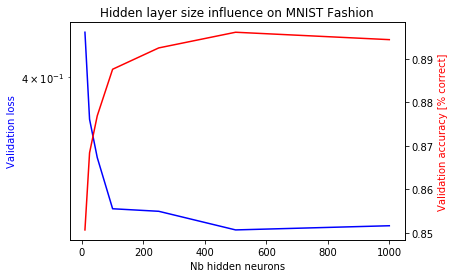

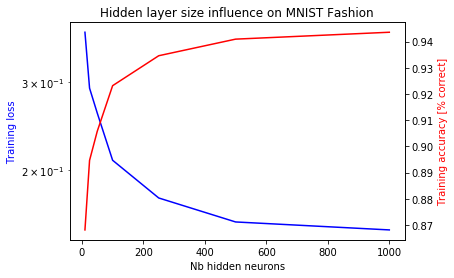

In [15]:
title = 'Hidden layer size influence on MNIST Fashion'

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.set_title(title, fontsize='large')

ax1.plot(hidden_neurons, min_loss_fashion, 'b-', label='val loss MNIST Fashion')
ax1.set_yscale('log')
ax2.plot(hidden_neurons, max_acc_fashion, 'r-', label='val acc MNIST Fashion')
ax1.set_ylabel('Validation loss', color='blue')
ax2.set_ylabel('Validation accuracy [% correct]', color='red')
ax1.set_xlabel('Nb hidden neurons');


fig = plt.figure(2)
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.set_title(title, fontsize='large')

ax1.plot(hidden_neurons, min_train_loss_fashion, 'b-', label='train loss MNIST')
ax1.set_yscale('log')
ax2.plot(hidden_neurons, max_train_acc_fashion, 'r-', label='train acc MNIST')
ax1.set_ylabel('Training loss', color='blue')
ax2.set_ylabel('Training accuracy [% correct]', color='red')
ax1.set_xlabel('Nb hidden neurons');

Answer to question 2:

We can see that the trend is in accordance with the theorem. But for high width of the hidden layer, the dimensional space introduced by the hidden units generates more local minima which can result in a weaker solution. This means that a solution exists for the function but our network does not necessarily learn it. Since the normal MNIST problem is rather simple, our model learns it correctly. But in the case of the MNIST Fashion it is more complex and can find a non optimal solution.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

#### 5.1

In [50]:
net_three_hidden = construct_mlp_for_mnist(3, x_train.shape[1], [50, 50, 50], ['relu', 'relu', 'relu'])
net_three_hidden.summary()

max_epochs = 100

net_three_hidden.compile(loss='categorical_crossentropy',
                       optimizer=Adam(),
                       metrics=['accuracy'])

history_three_hidden = net_three_hidden.fit(x_fashion_train, y_fashion_train,
                                        batch_size=minibatch_size,
                                        epochs=max_epochs,
                                        verbose=1,
                                        validation_data=(x_fashion_test, y_fashion_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_39 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_40 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_41 (Dense)             (None, 10)                510       
Total params: 44,860
Trainable params: 44,860
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.6018 - acc: 0.7919 - val_loss: 0.4465 - val_acc: 0.8393
Epoch 2/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.

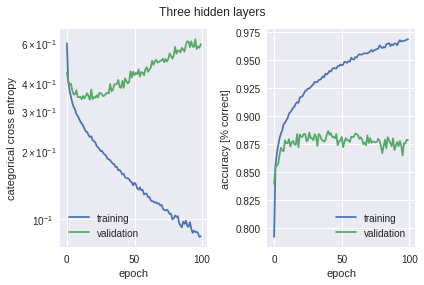

In [51]:
figure = plot_history(history_three_hidden, 'Three hidden layers')

In [52]:
np.max(history_three_hidden.history['val_acc'])

0.8866

In [0]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Activation

def construct_mlp_with_tricks_for_mnist(num_hidden_layers, input_dim, hidden_layer_sizes = [], activations=[], dropout_rate=0.5, lambda_reg=1e-5):
  net = Sequential()
  
  if num_hidden_layers > 0:
    net.add(Dense(hidden_layer_sizes[0], input_dim=input_dim, kernel_regularizer=regularizers.l2(lambda_reg)))
    net.add(BatchNormalization())
    net.add(Activation(activations[0]))
    net.add(Dropout(dropout_rate))
    for i in range(1, num_hidden_layers):
      net.add(Dense(hidden_layer_sizes[i], kernel_regularizer=regularizers.l2(lambda_reg)))
      net.add(BatchNormalization())
      net.add(Activation(activations[i]))
#       net.add(Dropout(dropout_rate))
    
    net.add(Dense(10, activation='softmax'))

  else:    
    net.add(Dense(10, activation='softmax', input_dim=input_dim, kernel_regularizer=regularizers.l2(lambda_reg)))
    
  return net

In [71]:
from keras import regularizers

net_three_hidden_tricks = construct_mlp_with_tricks_for_mnist(3, x_train.shape[1], [50, 50, 50], ['relu', 'relu', 'relu'], dropout_rate=0.3, lambda_reg=1e-6)
net_three_hidden_tricks.summary()

max_epochs = 100

net_three_hidden_tricks.compile(loss='categorical_crossentropy',
                              optimizer=Adam(),
                              metrics=['accuracy'])

history_three_hidden_tricks = net_three_hidden_tricks.fit(x_fashion_train, y_fashion_train,
                                                      batch_size=minibatch_size,
                                                      epochs=max_epochs,
                                                      verbose=1,
                                                      validation_data=(x_fashion_test, y_fashion_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 50)                39250     
_________________________________________________________________
batch_normalization_34 (Batc (None, 50)                200       
_________________________________________________________________
activation_35 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_35 (Batc (None, 50)                200       
_________________________________________________________________
activation_36 (Activation)   (None, 50)                0         
__________

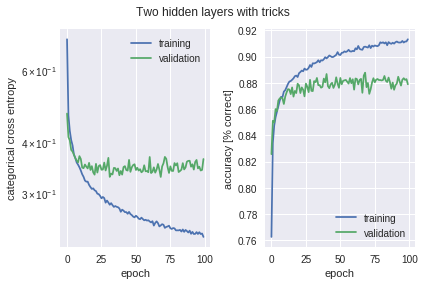

In [72]:
figure = plot_history(history_three_hidden_tricks, 'Two hidden layers with tricks')

In [73]:
np.max(history_three_hidden_tricks.history['val_acc'])

0.8877

#### 5.2

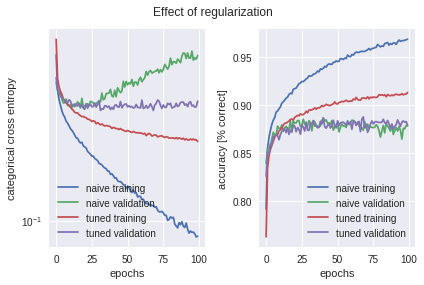

In [76]:
figure = comparison_plot(history_three_hidden, history_three_hidden_tricks, 'naive', 'tuned', 'Effect of regularization')

Answer to question 2 (comments):

We see that regularization does its job of reducing overfitting, but at the cost of a higher training error or at least a slowdown of learning. We see that the performance of both the regularized and the naive deep network is slightly better than the network with a single hidden layer.

#### 5.3

In [82]:
net_three_hidden_tuned = construct_mlp_with_tricks_for_mnist(3, x_train.shape[1], [50, 50, 50], ['relu', 'relu', 'relu'], dropout_rate=0.3, lambda_reg=1e-6)
net_three_hidden_tuned.summary()

max_epochs = 100

net_three_hidden_tuned.compile(loss='categorical_crossentropy',
                              optimizer=Adam(),
                              metrics=['accuracy'])

history_three_hidden_tuned = net_three_hidden_tuned.fit(x_train, y_train,
                                                      batch_size=minibatch_size,
                                                      epochs=max_epochs,
                                                      verbose=1,
                                                      validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 50)                39250     
_________________________________________________________________
batch_normalization_37 (Batc (None, 50)                200       
_________________________________________________________________
activation_38 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_38 (Batc (None, 50)                200       
_________________________________________________________________
activation_39 (Activation)   (None, 50)                0         
__________

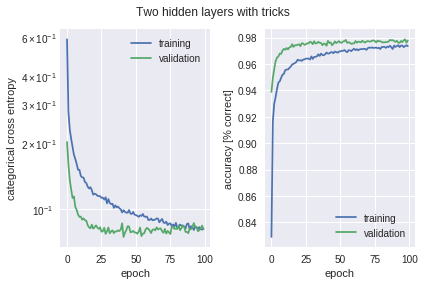

In [83]:
figure = plot_history(history_three_hidden_tuned, 'Two hidden layers with tricks on mnist')

In [84]:
np.max(history_three_hidden_tuned.history['val_acc'])

0.9787

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

Answer to question 3:

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

Answer to question 1:

Answer to question 2: